# Practical 4: Prediction Model Evaluation
<hr>
We have learned about linear and logistic regression. These methods facilitate supervised learning and enable us to approach prediction problems with a numerical (e.g., price) or categorical (e.g., repayment behavior=good or bad) target variable. 

In this session, we focus on practices to assess the accuracy of predictive models based on linear- or logistic regression. You will find more demos and small programming tasks. As to the tasks, remember that you are not supposed to know how to solve them right away. Rather, you are supposed to find solutions by discussing with peers, searching the web, or involving GenAI. That said, also recall that we never use GenAI without carefully inspecting generated codes **and** reading carefully the explanations of codes that are typically produced alongside generated codes. 

## Preliminaries
We will use the two data sets introduced in previous sessions, the *California Housing* data set from [practical #2](https://github.com/stefanlessmann/ESMT_IML/blob/main/notebooks/p2_modeling_housing_prices.ipynb) and the *HMEQ* data set from [practical #3](https://github.com/stefanlessmann/ESMT_IML/blob/main/notebooks/p3_classification.ipynb), which represent, respectively, a regression problem associated with modeling median house prices at the district level and a classification problem associated with predicting the repayment behavior of credit applicants (aka credit risk modeling). Below we reproduce codes from earlier sessions to import standard libraries, load the data sets, and perform some rudimentary data preprocessing where needed. Just execute those codes and we are ready to go.


In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#--------------------------------------------------------
# Loading the California Housing data set
#--------------------------------------------------------
from sklearn.datasets import fetch_california_housing
calh = fetch_california_housing(as_frame=True)  # get the data as a Pandas dataframe
# separate the data into feature matrix X and target variable y
X_calh = calh.data
y_calh = calh.target
print('Loaded California Housing data set with dimension (rows x columns) {} x {}'.format(*X_calh.shape))
#--------------------------------------------------------
# Training (aka fitting) a linear regression model
#--------------------------------------------------------
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(X_calh, y_calh)
#--------------------------------------------------------
# Loading the HMEQ credit risk data set
#--------------------------------------------------------
data_url = 'https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/master/data/hmeq.csv'
hmeq = pd.read_csv(data_url)  # standard pandas function to load tabular data in CSV format

# Convert a category with k different values into k-1 binary variables. 
X_hmeq = pd.get_dummies(hmeq, dummy_na=True, drop_first=True)
X_hmeq = X_hmeq.dropna().reset_index(drop=True)  # drop all cases with one or more missing value

# Separate the data into a matrix of feature values and a target variable
y_hmeq = X_hmeq.pop('BAD')
print('Loaded HMEQ credit risk data set with dimension (rows x columns) {} x {}'.format(*X_hmeq.shape))
#--------------------------------------------------------
# Training logistic regression-based classification model
#--------------------------------------------------------
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression().fit(X_hmeq, y_hmeq)

Loaded California Housing data set with dimension (rows x columns) 20640 x 8
Loaded HMEQ credit risk data set with dimension (rows x columns) 3515 x 18


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Foundations of ML Model Evaluation
As said, today we want to focus on prediction model evaluation. An ML model has many facets, that deserve being evaluated. Examples include:
- Interpretability
- Robustness
- Scalability
- and many more

Our focus, in this session, is **predictive accuracy**. We will learn practices to rigorously assess the forecasts coming from a predictive models. Speaking about predictive accuracy, you might remember this crucial slide.

<img src="https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/model_evaluation.png" width="1280" height="720" alt="Prediction Model Evaluation">

So, as discussed in class, the evaluation of prediction performance is all about comparing model-based forecasts to actual outcomes. There are **two key ingredients** to make this work. First, we must define what we mean by *performance*. For this, we need suitable accuracy or error measures. Second, we must organize our data suitably to simulate a real-world application of a model. Before diving into each of these stages, let's revisit how we obtain predictions in the first place. This is where the `predict()` function of `sklearn` comes in handy.

In [2]:
# Demo of how to obtain predictions from our regression model for the California Housing data
yhat_calh = lin_reg.predict(X_calh)  # forecasts of the median house value (i.e. the target) for the TRAINING data

# Visualize actual realizations of the target and the corresponding predictions by 
# putting them together in a data frame. 
df_Y_cf_Yhat = pd.DataFrame({'Median house value (Y)' : y_calh, 'Model prediction (Yhat)': yhat_calh})  
df_Y_cf_Yhat.head(5)

,Median house value (Y),Model prediction (Yhat)
0,4.526,4.131650
1,3.585,3.976606
2,3.521,3.676571
3,3.413,3.241598
4,3.422,2.413587


Equipped with this information, actual outcomes of the target variable and corresponding model predictions, we are ready to compute performance statistic. For example, the lecture introduced you to statistics like the *mean square error (MSE)* or *root mean square error (RMSE)*. Just to remind you, their mathematical definition was: 

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y}_i)^2 ;\qquad   \text{RMSE} = \sqrt{\text{MSE}}  $$

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^n |Y_i - \hat{Y}_i| $$

$$\text{MAPE} = \frac{1}{n} \sum_{i=1}^n \left|\frac{Y_i - \hat{Y}_i}{Y_i}\right|  $$

We could easily compute these error measures using `numpy`. Here is an example for the first two:

In [3]:
mse = 1/len(yhat_calh) * np.sum((y_calh - yhat_calh)**2)
rmse = np.sqrt(mse)
print('MSE of the regression model is {:.3f}'.format(mse))
print('RMSE of the regression model is {:.3f}'.format(rmse))

MSE of the regression model is 0.524
RMSE of the regression model is 0.724


Alternatively, the `sklearn` library provides ready-to-use functions to calculate standard error measures for regression models:

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mse  = mean_squared_error(y_calh, yhat_calh)
mae  = mean_absolute_error(y_calh, yhat_calh)
mape = mean_absolute_percentage_error(y_calh, yhat_calh)
print('MSE of the regression model is {:.3f}'.format(mse))
print('RMSE of the regression model is {:.3f}'.format(np.sqrt(mse)))
print('MAE of the regression model is {:.3f}'.format(mae))
print('MAPE of the regression model is {:.3f}'.format(mape))

MSE of the regression model is 0.524
RMSE of the regression model is 0.724
MAE of the regression model is 0.531
MAPE of the regression model is 0.317


**THE RMSE IS SUPPOSED TO SMALLER THAN MSE BUT NOTE THAT SINCE THE SCLAE OF THE DATA IS IN 100,000.**
Q) WHEN INTERPRETING THE NUMBERS, THEY CAN GO FROM 0 TO INFINITY, BUT IN WHAT RANGE IS THE ERROR SAY, "ACCEPTABLE"?


#### Exercise 1: 
With the help of the above demo for the linear regression model, your task is to produce predictions for the logistic regression model. Recall from [practical #3](https://github.com/stefanlessmann/ESMT_IML/blob/main/notebooks/p3_classification.ipynb) that logistic regression can give you two types of outputs, discrete classifications of whether an applicant is a good risk and probability predictions, capturing the model-estimated probability that an applicant is a good risk. Make sure you fully understand how these are different. 

Your task is to compute both types of predictions for every credit application in the HMEQ data set. Afterward, visualize these predictions next to the true repayment status (i.e., target variable) by putting everything into a pandas data frame, as exemplified above. 

In [5]:
# Your code for exercise 1
# Produce predictions for the HMEQ data using the trained logistic regression model
yhat_hmeq = log_reg.predict(X_hmeq)  # predicted classes (0 or 1) for the TRAINING data
yhat_hmeq_prob = log_reg.predict_proba(X_hmeq)[:, 1]  # predicted probabilities for class 1 for the TRAINING data   
# Visualize actual realizations of the target and the corresponding predictions by 
# putting them together in a data frame. 
df_Y_hmeq_Yhat = pd.DataFrame({'Actual class (Y)' : y_hmeq, 'Predicted class (Yhat)': yhat_hmeq, 'Predicted probability': yhat_hmeq_prob})  
df_Y_hmeq_Yhat.head(5)  

,Actual class (Y),Predicted class (Yhat),Predicted probability
0,1,0,0.320709
1,1,0,0.323940
2,0,0,0.276779
3,1,0,0.300877
4,0,0,0.247788


## Data Organization
At least for the case of regression, we have seen some common measures of forecast accuracy. We will come back to this point later, when examining the performance of our logistic regression model. Before doing this, however, let's look at the other key ingredient to forecast accuracy evaluation, data organization. 

Above, when producing predictions and comparing these to actually observed outcomes, we used all available data. Technically speaking, we did that when executing codes like:
```
lin_reg.predict(X_calh)

```
Here, we call the `predict()` function and use all our data, which we store in variable `X_calh`, as argument. When training our regression model, we called the corresponding Python function in a similar way, namely:
```
lin_reg = LinearRegression().fit(X_calh, y_calh)
```
You can find both statements above in the notebook if unsure. The point is that we use **the same data**, `X_calh`, for model training **and** when assessing the model. This is bad practice. The lecture already clarified data organization and future lecture sessions will further elaborate on this crucial point. We also learned about a better way to organize the data using the **holdout method**. 

<img src="https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/holdout_method.png" width="600" height="600" alt="Holdout Method">

To implement the holdout method in Python we typically use the `train_test_split()` function, which is available in the module `sklearn.model_selection`. 

#### Exercise 2: 

To familiarize yourself with the holdout method, write code to perform the following tasks:
- Import the `train_test_split()` function and have a look at its documentation
- Use this insight to write code that calls the function and splits the California Housing data set, that is your variable `X_calh`, randomly into a **training set** and a **test set**. Your test set should comprise 30% of the total data.
- Fit a linear regression model to the **training set**
- Assess your regression model by computing the MAE on the **test set**
- Also compute the MAE for the training set. Which error is larger?

In [19]:
# Your code for exercise 2
from sklearn.model_selection import train_test_split

Xtr_calh, Xts_calh, ytr_calh, yts_calh = train_test_split(X_calh, y_calh, test_size=0.3, random_state=111)
lin_reg = LinearRegression().fit(Xtr_calh, ytr_calh)
# visualise the model predictions on the test set
yhat_ts_calh = lin_reg.predict(Xts_calh)
df_Yts_calh_Yhat = pd.DataFrame({'Median house value (Y)' : yts_calh, 'Model prediction (Yhat)': yhat_ts_calh})  
df_Yts_calh_Yhat.head(5)  


,Median house value (Y),Model prediction (Yhat)
4585,2.750,1.504911
2597,0.798,0.919980
9477,0.960,1.907679
12020,0.996,1.796851
6114,1.330,1.813128


In [20]:
print('TEST set MAE of the regression model is {:.3f}'.format(
    mean_absolute_error(yts_calh, lin_reg.predict(Xts_calh))
))
print('TRAINING set MAE of the regression model is {:.3f}'.format(
    mean_absolute_error(ytr_calh, lin_reg.predict(Xtr_calh))
))

TEST set MAE of the regression model is 0.533
TRAINING set MAE of the regression model is 0.530


> The MAE on the TEST set is higher by 0.003. This makes sense but still shows good consistent performance as the train and test set is not that far off, which is a good sign. When thinking about this in USD terms, the difference might be significant enough which is what we expect that the training data has smaller errors than test errors (due to optimisation on the training data). Variance on the test data is larger and well distributed, and the test set is smaller.

Q) **so if the varriance in the test set is controlled for taking a large enough test set, what range of value can MAE or MSE fall in such that the error is acceptable and points to a "good model"?**

#### Extra challenge (Python beginners should skip this part)
You just compared the *test set performance* of the regression model to its *training set performance*. In theory, the error on the test set should be larger but it is possible that you did not observe this behavior. Perhaps, your previous comparison found both errors to be roughly the same. 

Note that your comparison has considered **one** random partitioning of the whole data into training and test set. To obtain a more reliable assessment of the training versus test error of the model, it would be useful to repeat the partitioning. If you already feel comfortable with coding, try to implement this better way of comparing the errors. More specifically, write code that implements the following logic:
```
SET parameter r, the number of repetition to some value > 100

REPEAT r times
    SPLIT California Housing data set randomly into training (80%) and test set (20%)
    FIT linear regression model on the training set
    PREDICT test set and compute MAE
    PREDICT training set and compute MAE
    STORE the MAE on training and on test set

PLOT the distribution of the training set MAE and that of the test set MAE over the r repetitions
```
For the visualization part, you can use any plot you deem fit. Remember that previous practicals have illustrated several standard forms to visualize distributions. 

In [ ]:
# Code for the extra challenge - PLEASE SKIP IF YOU THINK THIS WOULD COST YOU A LOT OF TIME 


### Cross-validation
Beyond splitting a data set into training and test set (aka the holdout method), we also introduced cross-validation, the process of partitioning a data set into *k* equally sized folds and repeatedly training a model on the combined data of k-1 folds and evaluating it on the left-out fold *k* times, such that each fold was used exactly once as the holdout or, synonymously , the *validation* fold. Relatively speaking, cross-validation is more reliable but also more costly than the simpler holdout method. It's costly because you have to train *k* models in total, which may cost a lot of time (e.g., when working with large data sets and/or complex ML algorithms). For the very same reason, cross-validation is also more reliable. You do not evaluate using one randomly sampled test set but carry out the evaluation *k* times.

<img src="https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/cross_validation.png" width="800" height="600" alt="Cross Validation">


The `sklearn` library offers you several ways to perform cross-validation. Each method has its own strengths and weaknesses, and the best choice depends on your specific requirements.
- `cross_val_score()` is easy to use but does not offer much flexibility. 
- `cross_validate()`  allows you to specify multiple evaluation metrics and provides more information about the training and testing procedure`.
- `KFold()` gives you full control over the cross-validation process. It is the most flexible implementation but requires writing more code compared to the other two methods.


Below, we demonstrate the `KFold()` option. Take a little time to review the code.

In [21]:
from sklearn.model_selection import cross_val_score, cross_validate, KFold

#--------------------------------------------------------------------------------
# Preliminaries
#--------------------------------------------------------------------------------
k = 10  # number of folds
kf = KFold(n_splits=k)  # initialize cross-validation process

# Say we want to assess our regression model in terms of multiple error
# measures, just as we did before. Here we create a list of all the
# error measures that interest us. 
error_measures = [mean_absolute_error,               # Note that the entries we put in this list   
                  mean_squared_error,                # are actually the functions used before.
                  mean_absolute_percentage_error]    # So we construct a list of Python functions
err_shorthand = ['MAE', 'MSE', 'MAPE']

# We will assess our regression model using each of the error.
# We will also measure performance on the test and training set,
# so we can compare, as before. To do all this, we need a place
# in which we can store the results, that is:
# k folds * 3 error measures * 2 sets (training and test).
# We use dictionaries for this purpose and initialize one dictionary
# for the test set results and another for the training set results. 
# In these dictionaries we use the name of a error measures as key, and 
# create an empty list to store the cross-validation results
train_errors = {measure: [] for measure in err_shorthand}
test_errors = {measure: [] for measure in err_shorthand}

#--------------------------------------------------------------------------------
# Iterating over the k folds
#--------------------------------------------------------------------------------
for train_index, test_index in kf.split(X_calh):  # so KFold gives as two arrays with the indices of the training and validation data of the current iteration
    X_train, X_test = X_calh.iloc[train_index], X_calh.iloc[test_index]  # we can use these arrays to index our original data set: here we construct the feature matrices
    y_train, y_test = y_calh[train_index], y_calh[test_index]  # and here we construct the arrays with the true targets

    # Fitting linear regression model on the training set of THIS ITERATION
    model = LinearRegression().fit(X_train, y_train)

    # Compute predictions on the test (and training) set of THIS ITERATION
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute model performance for every error measure we are interested in
    for i, measure in enumerate(error_measures):
        # Recall we created two dictionaries to store the results. First, we
        # take the training set results dictionary. We can use the current
        # error measure as key to index the dictionary. Doing so returns the 
        # value that the dictionary associates with this key. Given how we 
        # created the dictionary, this value is a list. Hence, we can use 
        # function .append() to add an element to the list. What value to append?
        # The value of the error measure, which we calculate inside the below
        # call of the append() function. 
        train_errors[err_shorthand[i]].append(measure(y_train, y_train_pred))
        test_errors[err_shorthand[i]].append(measure(y_test, y_test_pred))

#--------------------------------------------------------------------------------
# Aggregating the results
#--------------------------------------------------------------------------------
# The main work is done. We are ready to report and/or visualize our results

# For start, let's showcase the raw results for illustration 
print('The raw results per error measure are a list:')
print(test_errors['MAE'])  # same approach for any other error measure

The raw results per error measure are a list:
[0.5351667968101467, 0.5291050430667454, 0.6785147748452085, 0.4748574496302439, 0.6519784224910468, 0.5009218650229919, 0.3962986082790726, 0.6400626798803458, 0.6028617579309178, 0.4354469953096133]


In [22]:
# Given our results have the form of lists, we could also report averages
for i, measure in enumerate(error_measures):
    e = err_shorthand[i]  # shorthand form simplify the code
    print('\nEvaluating results in terms of {}'.format(e))
    print('-------------------------------------------')
    print('\tMEAN TEST set {} of the regression model is {:.3f}'.format(e, np.mean(test_errors[e])))
    print('\tMEAN TRAINING set {} of the regression model is {:.3f}'.format(e, np.mean(train_errors[e])))


Evaluating results in terms of MAE
-------------------------------------------
	MEAN TEST set MAE of the regression model is 0.545
	MEAN TRAINING set MAE of the regression model is 0.531

Evaluating results in terms of MSE
-------------------------------------------
	MEAN TEST set MSE of the regression model is 0.551
	MEAN TRAINING set MSE of the regression model is 0.523

Evaluating results in terms of MAPE
-------------------------------------------
	MEAN TEST set MAPE of the regression model is 0.325
	MEAN TRAINING set MAPE of the regression model is 0.317


/tmp/ipykernel_7332/3279962694.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot([train_errors[e], test_errors[e]], labels=['Train', 'Test'])
/tmp/ipykernel_7332/3279962694.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot([train_errors[e], test_errors[e]], labels=['Train', 'Test'])
/tmp/ipykernel_7332/3279962694.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot([train_errors[e], test_errors[e]], labels=['Train', 'Test'])


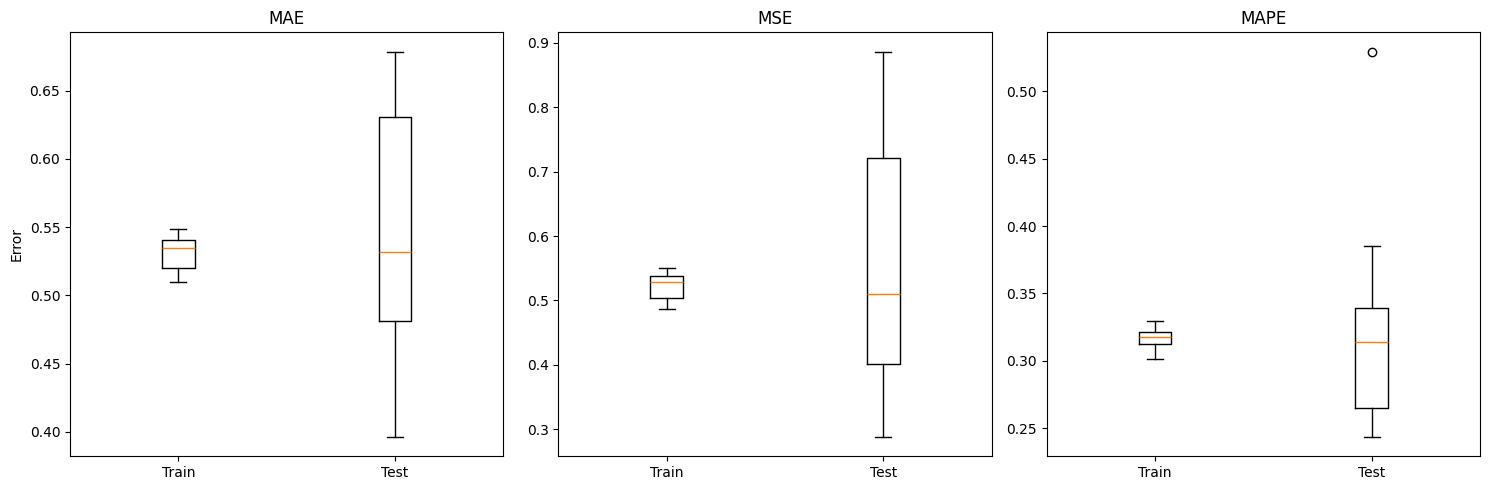

In [23]:
# And finally, we could create some suitable visualizations that depict how the error varies across folds
# For example, we can produce 3 box plots, one for each error measure, and compare test to training error

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure instance and specify the figure size

for i, measure in enumerate(error_measures):
    e = err_shorthand[i]  # shorthand form simplify the code
    
    # Create boxplot on each subplot
    axs[i].boxplot([train_errors[e], test_errors[e]], labels=['Train', 'Test'])
    axs[i].set_title(e)
    
axs[0].set_ylabel('Error')  # Just one y-axis label for the leftmost plot
# Show the plot
plt.tight_layout()
plt.show()


The coding demo was quite comprehensive. It is clearly time to give you a chance to try out your own coding skills. Prior to that, let's quickly note at least a few key findings from our analysis. 

First, the test error varies a lot more than does the training error. This is less surprising when you remember how cross-validation works. The test set of each iteration contains roughly $\frac{1}{k}$ of the data while the training set is much bigger, containing all $\frac{k-1}{k}$ remaining data.

Second, in this case, the median of the training and test set error distributions is roughly identical. This finding may look counterintuitive because we motivated cross-validation by saying that the performance on the training set is not a reliable estimate. While this statement is true, the results we observe are still plausible because we used linear regression. It is a characteristic of linear regression that training and test error deviate less than in other learning algorithms, as we will see in future sessions. 

### Exercise 3: 
Now that you saw the arguably most flexible and complex way to perform cross validation, your task is to simplify the above code using one of the other two options. This way, you will become familiar with all options and can make an informed choice next time you have to cross-validate a model. 

We continue with focusing on the California Housing data and linear regression. Depending on your preferences, we propose **two flavors of the exercise**. 

#### Option 3.a (easier)
Your task is to implement a 10-fold cross-validation of a regression model using the function `cross_val_score()`. More specifically:
- Examine the function's documentation and make sure you understand its key arguments.
- Write code to call the function such that it cross-validates a linear regression model for the California Housing data set
- Perform ten fold cross-validation
- Print the average performance of your model

Should the above tasks have proved too easy we have a little extra task for you: ask yourself what specific error measure your code has considered. It is not so clear, right? 

<hr/>

#### Option 3.b (harder)
This version is similar to the above but involves the function `cross_validate()`, multiple error measures, and a more sophisticated way to visualize the results. Specifically, 
- Examine the function's documentation and make sure you understand its key arguments
- Write code to call the function such that it cross-validates a linear regression model for the California Housing data set
- Perform ten fold cross-validation
- Your evaluation should comprise different error measures, namely, the MAE, the MSE, and the MAPE.
- Visualize the performance of the regression model for each error measure using a box-plot

> **Hint**: take a look into the [sklearn documentation on the scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#multimetric-scoring) to learn about ways of specifying error measures in a cross-validation process.

In [ ]:
# Your solution to exercise 3 
# check data dimensions
print('X_calh shape: ', X_calh.shape)
print('y_calh shape: ', y_calh.shape)


X_calh shape:  (20640, 8)
y_calh shape:  (20640,)


## Measuring classification performance
We cannot finish without discussing classification performance. The evaluation of a classifier differs from a regression model because our forecasting target is a categorical and often binary variable. We focus on the latter case and return to our HMEQ data set associated with predicting good and bad credit risks.

### Confusion matrix to assess discrete class predictions
Let's start with the more intuitive case in which we assess the binary class predictions of the logistic regression model. 

#### Exercise 4:
We start with an easy task to get started: 
- Split the HMEQ data set into training (70%) and test set (30%) using the holdout method
- Train a logistic regression model on the training set
- Compute discrete class predictions using the test set
- Store your predictions in a variable `class_pred`

You can find pretty much all the codes needed to solve this exercise in previous parts of the notebook.

In [ ]:
# Your code for exercise 4


Well done! Having sorted this bit, let's move on with the actual assessment. We introduced the **confusion matrix** as a standard way to assess a binary classification models. Of course, `sklearn` also supports the confusion matrix and, more specifically, its visualization. 

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
ConfusionMatrixDisplay.from_predictions(yts_hmeq,    # of course we use the test set
                                        class_pred,  # here, we assume you solved exercise 4 and created an array of discrete class predictions
                                        display_labels=['Good risk', 'Bad risk'])  # more readable labels for labeling the axes of our matrix
plt.show()

Just for the records, in case you are only interested in the entries of the confusion matrix, an easy way to get these is  as follows: 

In [ ]:
cmat = confusion_matrix(yts_hmeq, class_pred)  # Of course we use the test
print(cmat)

### ROC analysis
The confusion matrix suggests that our logistic regression is doing a very poor. It consistently predicts the class *Good risk*, meaning it would give every applicant credit. Put in statistical terms, the logistic regression acts like a **naive classifier** by always predicting the majority class in the data.  

Remember that the confusion matrix depicts the performance of a classifier for one specific **cut-off**. By default, the `predict()` function of `sklearn` sets this cut-off to 0.5. It may be that our logistic regression is a bit more useful that we think. Specifically, it may be that the default cut-off was inappropriate and that we would see a better performance with a different cut-off. Entry **ROC-analysis**.

ROC-analysis visualizes the performance of a classification model across **all possible cut-offs** and will give us a deeper understanding of whether the logistic regression is really naive or in fact able to distinguish good and bad payers to some extend. 

#### Exercise 5:
- Familiarize yourself with the function `RocCurveDisplay` which is available in the `sklearn.metrics` module.
- Write code to obtain **probability predictions** for the test set of the HMEQ data set (you can reuse `log_reg` for this task)
- Using the functionality of `RocCurveDisplay`, create an ROC curve.
- Write a short interpretation of the result. How well does logistic regression performs in your opinion?

In [ ]:
# Code for exercise 5


**Your interpretation of the ROC curve:**

# Well done! You completed another comprehensive notebook full of concepts, demos and programming tasks.